In [119]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")

Imports done


Temperature at 25 centimetres is:  17.0  degrees celsius


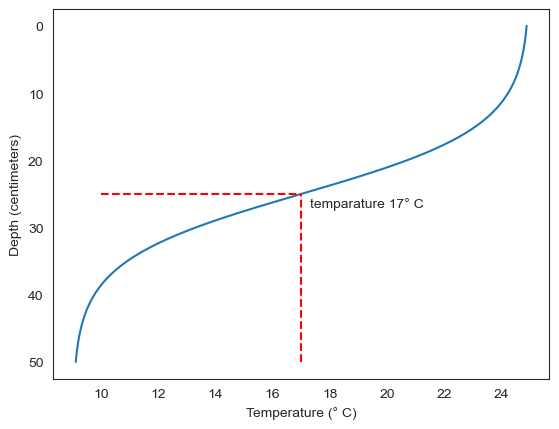

In [120]:
def g_gp(x,v):
    """
    Generative process, equation of sensory mapping: g_gp(x,v) at point x    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Hidden causal state, in this example not used
        
    OUTPUT:
        g_gp(x,v) - Temperature in degrees celsius
        
    """
    #t0= 20
    #y=(t0-8)/(0.2*x**2+1)+8
    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x,v):
    """
    Partial derivative of generative process towards x, equation of sensory mapping: g'_gp(x,v) at point x    
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g'_gp(x,v) - first partial derivative of generative process towards x
        
    """
    
    return -16/5 * np.exp(5-x/5) / (1+np.exp(5-x/5))**2

def ddg_gp(x,v):
    """
    Double partial derivative of generative process towards x, equation of sensory mapping: g''_gp(x) at point x  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g''_gp(x,v) - second partial derivative of generative process towards x
        
    """
    
    return (32*np.exp((2*x)/5+5))/(25*(np.exp(x/5)+np.exp(5))**3)-(16*np.exp(x/5+5))/(25*(np.exp(x/5)+np.exp(5))**2)

def dddg_gp(x,v):
    """
    3rd partial derivative of generative process towards x, equation of sensory mapping: g'''_gp(x) at point x  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g'''_gp(x,v) - third partial derivative of generative process towards x
        
    """
    
    return -16*np.exp(x/5+5)*(np.exp((2*x)/5)-4*np.exp(x/5+5)+np.exp(10))/(125*(np.exp(x/5)+np.exp(5))**4)

def ddddg_gp(x,v):
    """
    4th partial derivative of generative process towards x, equation of sensory mapping: g''''_gp(x) at point x  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g''''_gp(x,v) - 4th partial derivative of generative process towards x
        
    """
    
    return (16*np.exp(x/5+5)*(np.exp((3*x)/5)-11*np.exp((2*x)/5+5)+11*np.exp(x/5+10)-np.exp(15)))/(625*(np.exp(x/5)+np.exp(5))**5)

# in case you wondered how to calculated all the derivatives in an easy way: https://www.derivative-calculator.net/

# Show the temperature curve
x_show = np.arange (-0,50,0.01)
y_show = g_gp(x_show,0)
dy_show = dg_gp(x_show,0)
plt.plot(y_show, x_show)
#plt.plot(dy_show, x_show)
plt.ylabel('Depth (centimeters)')
plt.xlabel('Temperature (° C)')
plt.gca().invert_yaxis()
plt.vlines(17, 50, 25, colors='r', linestyles='dashed')
plt.hlines(25, 10,17, colors='r', linestyles='dashed')
plt.text(17.3,27,"temparature 17° C")
plt.show;

print('Temperature at 25 centimetres is: ', g_gp(25,0), ' degrees celsius')

In [121]:
test=30
print(g_gp(test,0),dg_gp(test,0),ddg_gp(test,0),dddg_gp(test,0),ddddg_gp(test,0))
#Compare with https://www.derivative-calculator.net/

13.303062741919922 -0.629158186372742 0.05814895851068702 0.0045216743060781635 -0.003161775650979668


In [122]:
a=-1
def f_gp(x, v):
    """
    Generative process, equation of motion: f_gp(x,v) at point x    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Hidden causal state, in this example not used
        
    OUTPUT:
        f_gp(x,v) - Speed of depth position in centimetres 
        
    """
    return a*x + v

def df_gp(x, v):
    """
    Partial derivative of generative process towards x, equation of motion: f'_gp(x) at point x    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Hidden causal state, in this example not used
        
    OUTPUT:
        df_gp(x, v) - first derivative of the equation of motion
        
    """
    return a
        

In [123]:
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 5+dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points
print ('Amount of data points: ', N)
print ('Starting with', t[0:5])
print ('Ending with', t[N-5:N])
print ('Data elements', np.size(t))

Amount of data points:  1001
Starting with [0.    0.005 0.01  0.015 0.02 ]
Ending with [4.98  4.985 4.99  4.995 5.   ]
Data elements 1001


In [124]:
def makeNoise(C,s2,t):
    """
    Generate random noise series with temporal smoothness with desired covariance matrix
    Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)
    
    INPUTS:
        C       - desired covariance matrix
        s2      - smoothness parameter (>0), variance of the filter (sigma^2)
                  - s2 <= 1e-5 -> produces white noise
        t       - timeline 
        
    OUTPUT:
        ws       - noise sequence with temporal smoothness
    """
    
    if np.size(C)== 1:
        n = 1
    else:
        n = C.shape[1]  # dimension of noise
        
    # Create the white noise with correct covariance
    N = np.size(t)      # number of elements
    L =cholesky(C, lower=True)  #Cholesky method
    w = np.dot(L,np.random.randn(n,N))
    
    if s2 <= 1e-5: # return white noise
        return w
    else: 
        # Create the noise with temporal smoothness
        P = toeplitz(np.exp(-t**2/(2*s2)))
        F = np.diag(1./np.sqrt(np.diag(np.dot(P.T,P))))
        K = np.dot(P,F)
        ws = np.dot(w,K)
        return ws

In [125]:
def temporalC(p,s2):
    """
    Construct the temporal covariance matrix S for noise with embedding order p and smoothness parameter s
    
    Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)
    
    INPUTS:
        p       - embedding order (>0)
        s2      - smoothness parameter (>0), variance of the filter (sigma^2)
        
    OUTPUT:
        S       - temporal covariance matrix ((p+1) x (p+1))
    """ 

    q = np.arange(p+1)
    
    r = np.zeros(1+2*(p))
    r[2*q] = np.cumprod(1-2*q)/(2*s2)**(q)    
    
    S = np.empty([0,p+1])

    for i in range(p+1):
        S = np.vstack([S,r[q+i]])
        r = -r
           
    return S 

In [126]:
def derivativeD(p):
    """
    Construct derivative operator with embedding order p 
    Shifts all variables of a vector up by one and adds a zero at the bottom 
    
    Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)
    
    INPUTS:
        p       - embedding order (>0)
        
    OUTPUT:
        D       - derivative matrix ((p+1) x (p+1))
    """ 
    D = toeplitz(np.zeros([1,p+1]),np.append(np.array([0,1]),np.zeros([1,p-1])))
           
    return D

In [127]:
def generalize(y,p):
    """
    Construct generalised value with embedding order p 
    By [y,0,0...]
    
    INPUTS:
        y       - Input sensory signal
        p       - embedding order (>0)
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')    
    
    if np.shape(y)==(p+1, 1):
        # Generalised value, use it
        y_tilde=y;
        return y_tilde
    
    # Generalize sensory observation by adding zero's
    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y

    return y_tilde

def sensor_generalize_exact(y,p,x,v):
    """
    Construct generalised sensory observations with embedding order p 
    Generalize sensory observation by calculating the exact value 
    
    For this example it has been calculated upto 3 derivatives

    INPUTS:
        y       - Input sensory signal
        p       - embedding order (>0)
        x       - Hidden state, needed to calculate the exact higher derivatives
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')       

    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y
    if p>=1:
        y_tilde[1] = dg_gp(x,v)*f_gp(x,v) # note that function f already expresses the motion of x (\dot x), hence not df_gp needed but f_gp
    if p>=2:
        y_tilde[2] = ddg_gp(x,v)*f_gp(x,v)*f_gp(x,v) + dg_gp(x,v)*df_gp(x,v)*f_gp(x,v)
    if p>=3:
        y_tilde[3] = dddg_gp(x,v)*f_gp(x,v)**3 + 2*ddg_gp(x,v)*f_gp(x,v)**2*df_gp(x,v) + df_gp(x,v)*(ddg_gp(x,v)*f_gp(x,v)*f_gp(x,v) + dg_gp(x,v)*df_gp(x,v)*f_gp(x,v))
    
    return y_tilde

def sensor_generalize_backward(y,i,p):
    """
    Construct generalised sensory observations with embedding order p 
    Generalize sensory observation by approximating the derivaties from past observations
    
    For this example it has been calculated upto 4 derivatives
    
    INPUTS:
        y       - Input sensory signal (array including all history thus far)
        i       - Current timestamp, so y[i] is the current non-generalised sensory signal
        p       - embedding order (>=0)
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')    
    
    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y[i]
    if p>=1:
        y_tilde[1] = (y[i]-y[i-1])/dt
        #print('Generalise backward input : ', y[i],' + ',y[i-1])
    if p>=2 and i>=2:
        y_tilde[2] = (y[i]-2*y[i-1]+y[i-2])/dt**2
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2])
    if p>=3 and i>=3:
        y_tilde[3] = (y[i]-3*y[i-1]+3*y[i-2]-y[i-3])/dt**3
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2],' + ',y[i-3])
    if p>=4 and i>=4:
        y_tilde[4] = (y[i]-4*y[i-1]+6*y[i-2]-4*y[i-3]+y[i-4])/dt**4
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2],' + ',y[i-3],' + ',y[i-4])
          
    return y_tilde

def standard_vec(p):
    x = np.zeros((p+1,1))
    x[0] = 1
    return x

def standard_vec_inv(p):
    x = np.ones((p+1,1))
    x[0] = 0
    return x

def motion_generalize_exact(p,x,v):
    """
    Construct generalised motion with embedding order p 
    Generalize the motion by calculating the exact value 
    
    For this example it has been calculated upto 3 derivatives

    INPUTS:
        p       - embedding order (>0)
        x       - Hidden state
        v       - Hidden cause
        
    OUTPUT:
        x_tilde - Generalised motion
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')       

    x_tilde = np.zeros((p+1,1))
    x_tilde[0] = x
    if p>=1:
        x_tilde[1] = f_gp(x,v)
    if p>=2:
        x_tilde[2] = df_gp(x,v)*f_gp(x,v)
    if p>=3:
        x_tilde[3] = df_gp(x,v)*df_gp(x,v)*f_gp(x,v)
        
    return x_tilde    

In [128]:
class ai_capsule():
    """
        Class that constructs a group of neurons that perform Active Inference for one hidden state, one sensory input, one prior
        In neurology it could e.g. represent a (micro) column or a neuron assembly

        Version 0.2 including generalised coordinates of motion
    """
    def __init__(self, dt, mu_x_init, p, Sigma_w, Sigma_z, a_mu, s2_w, s2_z):  
        
        self.dt = dt    # integration step
        self.mu_x= mu_x_init # initializing the hidden state, in generalised coordinates of motion
        self.p = p      # embedding order, number of derevatives in generalised coordinates of motion
        self.F = 0      # Free Energy
        self.eps_x =  np.zeros((p+1,1))   # epsilon_x, prediction error on hidden state,  in generalised coordinates of motion
        self.eps_y = np.zeros((p+1,1)) # epsilon_y, prediction error on sensory measurement,  in generalised coordinates of motion
        self.Sigma_w = Sigma_w # Estimated variance of the hidden state equals variance of the prior
        self.Sigma_z = Sigma_z # Estimated variance of the sensory observation 
        self.s2_w = s2_w # Estimated variance of the Gaussian filter used to create the smoothened noise w
        self.s2_z = s2_z # Estimated variance of the Gaussian filter used to create the smoothened noise z
        self.alpha_mu = a_mu # Learning rate of the gradient descent mu (hidden state)
        self.D = derivativeD(self.p)
        self.I = np.identity(self.p+1)
        self.Pi_w = inv(np.kron(temporalC(self.p,self.s2_w),self.Sigma_w)) # precision matrix of smoothened noise w
        self.Pi_z = inv(np.kron(temporalC(self.p,self.s2_z),self.Sigma_z)) # precision matrix of smoothened noise z
        self.a=-1 # same as the generative model
        self.Atilde= self.a * self.I
        #self.c=1
        #self.Ctilde= self.c * self.I
        self.std_vec_inv=standard_vec_inv(p)
        self.std_vec=standard_vec(p)
    
    def inference_step (self, i, mu_v, y):
        """
        Perceptual inference    

        INPUTS:
            i       - tic, timestamp
            mu_v    - Hierarchical prior input signal (mean) at timestamp,  in generalised coordinates of motion
            y       - sensory input signal at timestamp, in generalised coordinates of motion

        INTERNAL:
            mu_x      - Belief or hidden state estimation, in generalised coordinates of motion

        """

        # Calculate prediction errors
        self.eps_x = (self.D-self.Atilde).dot(self.mu_x) - mu_v  # prediction error hidden state

        print(mu_v)
        print(self.D-self.Atilde)
        self.eps_y = y - self.std_vec*g_gp(self.mu_x[0],mu_v[0]) - self.std_vec_inv * dg_gp(self.mu_x[0],mu_v[0]) * self.mu_x #prediction error sensory observation
        print(self.eps_x)
        # In case a linear state space model is used with linear equation of sensory mapping the below calculation is equivalent
        #self.eps_y = y - self.Ctilde.dot(self.mu_x) #prediction error sensory observation
        
        #print('mu_x=', self.mu_x[0],'mu_y=', g_gp(self.mu_x[0],mu_v[0]), 'x_dot',self.mu_x[1])
        #print( 'ex',self.eps_x)
        #print( 'ey',self.eps_y)

        # Free energy gradient
        dFdmu_x = (self.D-self.Atilde).T.dot(self.Pi_w).dot(self.eps_x) - (dg_gp(self.mu_x[0],mu_v[0]) * self.I).T.dot(self.Pi_z).dot(self.eps_y)
        #print(dFdmu_x, "dFdmu_x")
        # In case a linear state space model is used with linear equation of sensory mapping the below calculation is equivalent
        #dFdmu_x = (self.D-self.Atilde).T.dot(self.Pi_w).dot(self.eps_x) - self.Ctilde.T.dot(self.Pi_z).dot(self.eps_y)
        
        # Perception dynamics
        dmu_x   = np.dot(self.D,self.mu_x) - self.alpha_mu * dFdmu_x  
        #print(dmu_x, "dmu_x")
        self.mu_x = self.mu_x + self.dt * dmu_x
        
        
        # Calculate Free Energy to report out
        self.F= 0.5*( self.eps_x.T.dot(self.Pi_w).dot(self.eps_x) + self.eps_y.T.dot(self.Pi_z).dot(self.eps_y)) #+ np.log(self.Sigma_w * self.Sigma_z) )
        
        return self.F.item(0), self.mu_x[0] , g_gp(self.mu_x[0],mu_v[0])

In [131]:
def simulation (v, mu_v, x_init, Sigma_w, Sigma_z, s2_w, s2_z, noise, a_mu, p, gen_y):
    """
    Simulation for perceptual inference in a dynamic environment with generalised coordinates     
   
    INPUTS:
        v          - Hydars actual desired depth, used in generative model
        mu_v       - Hydars prior belief/hypotheses of the desired depth
        x_init     - Hydars actual starting depth, used in generative model
        Sigma_w    - Variance of the hidden state 
        Sigma_z    - Variance of the sensory observation 
        s2_w       - The variance of the Gaussian filter used to create the smoothened noise w
        s2_z       - The variance of the Gaussian filter used to create the smoothened noise z
        noise      - white, smooth or none
        a_mu       - Learning rate for mu
        p          - Embedding order of generalised motions of the generative model
        gen_y      - Method to generalize the sensory observations: exact, backward, extend
        
    """
    
    # Init tracking
    mu_x = np.zeros(N) # Belief or estimation of hidden state 
    F = np.zeros(N) # Free Energy of AI neuron
    mu_y = np.zeros(N) # Belief or prediction of sensory signal


    # Construct noise signals with temporal smoothness:
    np.random.seed(42)
    w = makeNoise(Sigma_w,s2_w,t)
    z = makeNoise(Sigma_z,s2_z,t)

    # Init the generalised process
    x = np.zeros(N) # True hidden state
    y = np.zeros(N) # Sensory signal as input to AI neuron
    x[0] = x_init
    if noise == 'white':
        y[0]=g_gp(x[0],v) + np.random.randn(1) * Sigma_z
    elif noise == 'smooth':
        y[0]=g_gp(x[0],v)+ z[0,0] 
    else: #no noise
        y[0]=g_gp(x[0],v)

    # Create active inference neuron
    
    if p==0:
        # Not generalised, use the basic version
        # initializing the initial hidden state by Hydars best guess: hierarchical prior
        mu_x_init=mu_v
        capsule = ai_capsule_v1(dt, mu_x_init, Sigma_w, Sigma_z, a_mu) 
    else:
        # Generalised
        mu_v_tilde=generalize(mu_v,p) # generalize the prior
        # initializing the initial hidden state by Hydars best guess: hierarchical prior
        mu_x_init_tilde = mu_v_tilde
        # alternative initializing the initial hidden state by Hydars the exact actual movement of the hidden state
        #mu_x_init_tilde = motion_generalize_exact(p, x_init,v)
        capsule = ai_capsule(dt, mu_x_init_tilde, p, Sigma_w, Sigma_z, a_mu, s2_w, s2_z) 

    ssim = time.time() # start sim
    
    # Simulation

    for i in np.arange(1,N):
        # Generative process
        if noise == 'white':
            x_dot= f_gp(x[i-1],v) + np.random.randn(1) * Sigma_w
            x[i]= x[i-1] + dt*x_dot
            y[i] = g_gp(x[i],v) + np.random.randn(1) * Sigma_z
        elif noise == 'smooth':
            x_dot= f_gp(x[i-1],v) + w[0,i]
            x[i]= x[i-1] + dt*x_dot
            y[i] = g_gp(x[i],v) + z[0,i]
        else: #no noise
            x_dot=f_gp(x[i-1],v)
            x[i]= x[i-1] + dt*x_dot
            y[i] = g_gp(x[i],v)

        #Active inference
        #print('x=',x[i],'y=',y[i], 'x_dot=',x_dot)
        if p==0:
            F[i], mu_x[i], mu_y[i] = capsule.inference_step(i,mu_v,y[i])
        else:
            # Create generalize sensory observations
            if gen_y=='exact':
                y_tilde = sensor_generalize_exact(y[i],p,x[i],v)
                #print(y_tilde)
            elif gen_y=='backward':
                y_tilde = sensor_generalize_backward(y,i,p)
            elif gen_y=='extend':
                y_tilde = generalize(y[i],p)
            else:
                raise ValueError('Unknown method to create sensory observation in generalised coordinates of motion') 
            F[i], mu_x[i], mu_y[i] = capsule.inference_step(i,mu_v_tilde,y_tilde)

    
    # Print the results
    tsim = time.time() - ssim
    #print('Simulation time: ' + "%.2f" % tsim + ' sec' )

    return F, mu_x, mu_y, x, y

[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[0.]
 [0.]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[0.01478775]
 [0.        ]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 2.93802676e-02]
 [-7.39387452e-05]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.04377948]
 [-0.00022082]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.05798731]
 [-0.00043966]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.07200563]
 [-0.00072949]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.08583635]
 [-0.00108933]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.09948131]
 [-0.00151823]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.11294238]
 [-0.00201525]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.1262214 ]
 [-0.00257944]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.13932017]
 [-0.00320989]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.15224051]
 [-0.00390567]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.16498422]
 [-0.00466587]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.17755307]
 [-0.0054896 ]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 0.18994881]
 [-0.00637595]]
[[25.]
 [ 0.]]
[[1. 1.]
 [0. 1.]]
[[ 

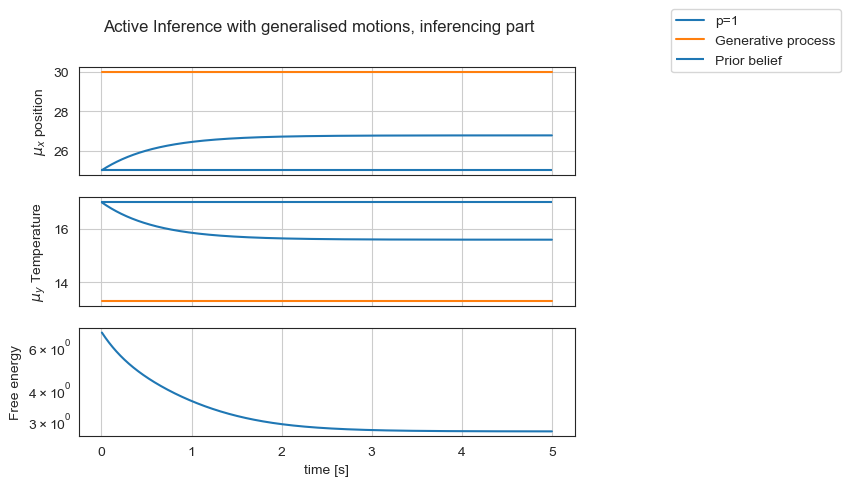

In [130]:
x_init = 30.0 # generative process initial depth Hydar
v = 30.0 # generative process target depth Hydar
mu_v = 25.0 # generative model, Hydars prior belief of the (target) depth

F1, mu_x1, mu_y1, x1, y1 = simulation(v,mu_v,x_init,1,1,1/64,1/64,'no noise',1,1,'exact') # emedding order p=1
# F2, mu_x2, mu_y2, x2, y2 = simulation(v,mu_v,x_init,1,1,1/64,1/64,'no noise',1,2,'exact') # emedding order p=2
# F3, mu_x3, mu_y3, x3, y3 = simulation(v,mu_v,x_init,1,1,1/64,1/64,'no noise',1,3,'exact') # emedding order p=3

# Plot results:
fig, axes = plt.subplots(3, 1, sharex='col');
fig.suptitle('Active Inference with generalised motions, inferencing part');
axes[0].plot(t[1:],mu_x1[1:],label='p=1');
# axes[0].plot(t[1:],mu_x2[1:],label='p=2');
# axes[0].plot(t[1:],mu_x3[1:],label='p=3');

axes[0].plot(t[1:],x1[1:],label='Generative process');
axes[0].hlines(mu_v, 0,T, label='Prior belief')
axes[0].set_ylabel('$\mu_x$ position');
axes[0].ticklabel_format(useOffset=False)
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axes[0].grid(1);
axes[1].plot(t[1:],mu_y1[1:],label='p=1');
# axes[1].plot(t[1:],mu_y2[1:],label='p=2');
# axes[1].plot(t[1:],mu_y3[1:],label='p=3');

axes[1].plot(t[1:],y1[1:],label='Generative process');
axes[1].hlines(g_gp(mu_v,0), 0,T, label='Prior belief')
axes[1].set_ylabel('$\mu_y$ Temperature');
axes[1].ticklabel_format(useOffset=False)
axes[1].grid(1);
axes[2].semilogy(t[1:],F1[1:],label='p=1');
# axes[2].semilogy(t[1:],F2[1:],label='p=2');
# axes[2].semilogy(t[1:],F3[1:],label='p=3');

axes[2].set_xlabel('time [s]');
axes[2].set_ylabel('Free energy');
axes[2].grid(1);


print('p=1', mu_x1[-1]) #show the last
# print('p=2', mu_x2[-1]) #show the last
# print('p=3', mu_x3[-1]) #show the last